<a href="https://colab.research.google.com/github/omkarsarde/Adversarial-Attack-on-Deep-Learning-Models/blob/main/GPU16GHorizontal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Horizontal Scaling
# Device: GPU
# Memory: 16 GB 

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c1b1389f-dcda-8a3e-46a2-b0e674b8a530)


In [2]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow import keras
import time
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

In [3]:
# Load the dataset directly from tensorflow
pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

In [4]:
# Preprocess the data
# data is in uint8, convert to float32
# also as we are using a off the shelf model, one hot encode the label
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [5]:
# STANDARD VGG16 Model
standard_Model = VGG16()
standard_Model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
standard_Model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [6]:
# Vgg16 based model We will Use
# THIS MODEL IS NOT PRETRAINED
new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [7]:
# Class to log times per epoch as 
# we will use TIME based comparison between hardware
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [8]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=128).shuffle(1000).repeat().batch(128).prefetch(4)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=128).repeat().batch(128).prefetch(4)

In [9]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback = TimeHistory()
# history = model.fit(train_data_batch, epochs = 5, callbacks=[ time_callback], validation_data = valid_data_batch, verbose=1)
history = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=1, epochs=5,callbacks=[time_callback], steps_per_epoch=2048, validation_steps=256)


Epoch 1/5
   6/2048 [..............................] - ETA: 5:30 - loss: 0.6925 - acc: 0.5352WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0521s vs `on_train_batch_end` time: 0.0921s). Check your callbacks.


2048/2048 [==============================] - 351s 169ms/step - loss: 0.4058 - acc: 0.8093 - val_loss: 0.3589 - val_acc: 0.8307
Epoch 2/5
2048/2048 [==============================] - 345s 169ms/step - loss: 0.2336 - acc: 0.9067 - val_loss: 0.3958 - val_acc: 0.8389
Epoch 3/5
2048/2048 [==============================] - 346s 169ms/step - loss: 0.1705 - acc: 0.9356 - val_loss: 0.4573 - val_acc: 0.8255
Epoch 4/5
2048/2048 [==============================] - 345s 169ms/step - loss: 0.1387 - acc: 0.9493 - val_loss: 0.3325 - val_acc: 0.8635
Epoch 5/5
2048/2048 [==============================] - 346s 169ms/step - loss: 0.1167 - acc: 0.9581 - val_loss: 0.4230 - val_acc: 0.8443


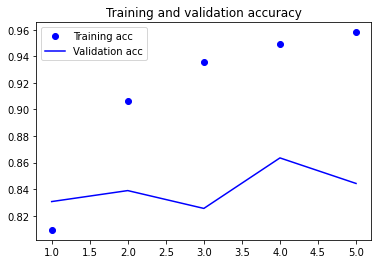

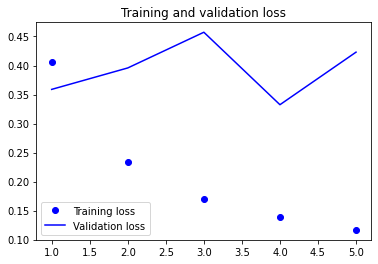

In [10]:
# Model Statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
# Time per epoch  in seconds
time_callback.times

[351.2074718475342,
 345.5008249282837,
 345.8541259765625,
 345.22304940223694,
 345.7641251087189]

In [16]:
# Model performance on Test Data
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=128).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Test set accuracy is 0.7797


In [17]:
# Vgg16 based model We will Use

new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [18]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=64).shuffle(1000).repeat().batch(128).prefetch(4)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=64).repeat().batch(128).prefetch(4)

In [19]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback = TimeHistory()
history = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=1, epochs=5,callbacks=[time_callback], steps_per_epoch=2048, validation_steps=256)

Epoch 1/5
   6/2048 [..............................] - ETA: 5:29 - loss: 0.6939 - acc: 0.4883WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0521s vs `on_train_batch_end` time: 0.1103s). Check your callbacks.


2048/2048 [==============================] - 344s 168ms/step - loss: 0.3840 - acc: 0.8259 - val_loss: 0.3427 - val_acc: 0.8512
Epoch 2/5
2048/2048 [==============================] - 343s 168ms/step - loss: 0.2176 - acc: 0.9145 - val_loss: 0.3151 - val_acc: 0.8669
Epoch 3/5
2048/2048 [==============================] - 343s 167ms/step - loss: 0.1654 - acc: 0.9385 - val_loss: 0.3782 - val_acc: 0.8411
Epoch 4/5
2048/2048 [==============================] - 343s 167ms/step - loss: 0.1355 - acc: 0.9507 - val_loss: 0.3795 - val_acc: 0.8545
Epoch 5/5
2048/2048 [==============================] - 343s 167ms/step - loss: 0.1142 - acc: 0.9592 - val_loss: 0.4683 - val_acc: 0.8433


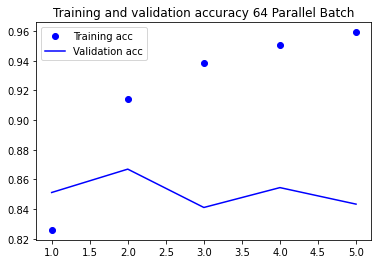

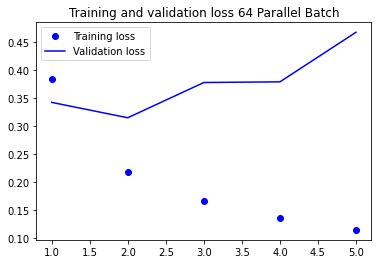

In [25]:
# Model Statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy 64 Parallel Batch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss 64 Parallel Batch')
plt.legend()
plt.show()

In [23]:
# Time per epoch in seconds
time_callback.times

[344.44909024238586,
 343.27075386047363,
 342.80497694015503,
 342.92636251449585,
 342.55343532562256]

In [24]:
# Model performance on Test Data
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=64).batch(128).prefetch(4)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8298


In [26]:
# Vgg16 based model We will Use

new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [27]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1000).repeat().batch(128).prefetch(4)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(4)

In [28]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback = TimeHistory()
history = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=1, epochs=5,callbacks=[time_callback], steps_per_epoch=2048, validation_steps=256)

Epoch 1/5
   6/2048 [..............................] - ETA: 5:31 - loss: 0.6931 - acc: 0.5247WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0529s vs `on_train_batch_end` time: 0.1108s). Check your callbacks.


2048/2048 [==============================] - 344s 167ms/step - loss: 0.4634 - acc: 0.7629 - val_loss: 0.3776 - val_acc: 0.8357
Epoch 2/5
2048/2048 [==============================] - 342s 167ms/step - loss: 0.2425 - acc: 0.9026 - val_loss: 0.3649 - val_acc: 0.8548
Epoch 3/5
2048/2048 [==============================] - 341s 167ms/step - loss: 0.1754 - acc: 0.9343 - val_loss: 0.3463 - val_acc: 0.8691
Epoch 4/5
2048/2048 [==============================] - 342s 167ms/step - loss: 0.1416 - acc: 0.9481 - val_loss: 0.3009 - val_acc: 0.8852
Epoch 5/5
2048/2048 [==============================] - 342s 167ms/step - loss: 0.1192 - acc: 0.9574 - val_loss: 0.3611 - val_acc: 0.8608


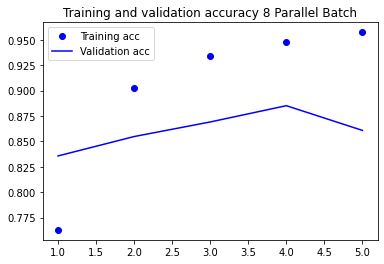

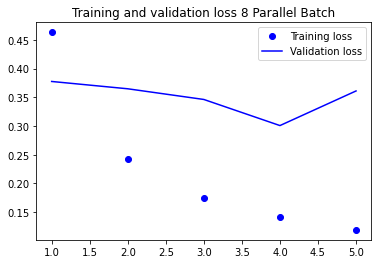

In [29]:
# Model Statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy 8 Parallel Batch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss 8 Parallel Batch')
plt.legend()
plt.show()

In [30]:
# Time per epoch in seconds
time_callback.times

[344.1942377090454,
 341.65522956848145,
 341.1963918209076,
 341.5145616531372,
 341.53519916534424]

In [31]:
# Model performance on Test Data
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(4)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8170


In [32]:
# Vgg16 based model We will Use

new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [33]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=128).shuffle(1000).repeat().batch(64).prefetch(4)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=128).repeat().batch(64).prefetch(4)

In [34]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback = TimeHistory()
history = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=1, epochs=5,callbacks=[time_callback], steps_per_epoch=4096, validation_steps=512)

Epoch 1/5
   6/4096 [..............................] - ETA: 5:56 - loss: 0.6933 - acc: 0.4531WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0305s vs `on_train_batch_end` time: 0.0476s). Check your callbacks.


4096/4096 [==============================] - 375s 91ms/step - loss: 0.3550 - acc: 0.8428 - val_loss: 0.3383 - val_acc: 0.8580
Epoch 2/5
4096/4096 [==============================] - 371s 91ms/step - loss: 0.1920 - acc: 0.9262 - val_loss: 0.3893 - val_acc: 0.8480
Epoch 3/5
4096/4096 [==============================] - 372s 91ms/step - loss: 0.1451 - acc: 0.9466 - val_loss: 0.4447 - val_acc: 0.8380
Epoch 4/5
4096/4096 [==============================] - 372s 91ms/step - loss: 0.1188 - acc: 0.9576 - val_loss: 0.4723 - val_acc: 0.8419
Epoch 5/5
4096/4096 [==============================] - 372s 91ms/step - loss: 0.0972 - acc: 0.9661 - val_loss: 0.5836 - val_acc: 0.8218


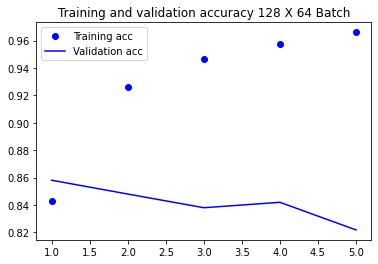

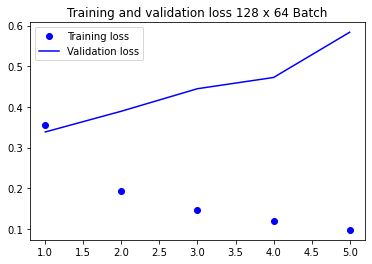

In [35]:
# Model Statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy 128 X 64 Batch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss 128 x 64 Batch')
plt.legend()
plt.show()

In [36]:
# Time per epoch in seconds
time_callback.times

[375.0708644390106,
 371.3307991027832,
 371.62411284446716,
 371.8552372455597,
 371.8321487903595]

In [37]:
# Model performance on Test Data
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=128).batch(64).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=512, verbose=0)[1]))

Test set accuracy is 0.7865


In [38]:
# Vgg16 based model We will Use

new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [39]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=64).shuffle(1000).repeat().batch(64).prefetch(4)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=64).repeat().batch(64).prefetch(4)

In [40]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback = TimeHistory()
history = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=1, epochs=5,callbacks=[time_callback], steps_per_epoch=4096, validation_steps=512)

Epoch 1/5
   6/4096 [..............................] - ETA: 6:01 - loss: 0.6934 - acc: 0.4688WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0311s vs `on_train_batch_end` time: 0.0572s). Check your callbacks.


4096/4096 [==============================] - 374s 91ms/step - loss: 0.3642 - acc: 0.8401 - val_loss: 0.3307 - val_acc: 0.8617
Epoch 2/5
4096/4096 [==============================] - 373s 91ms/step - loss: 0.1982 - acc: 0.9238 - val_loss: 0.3232 - val_acc: 0.8665
Epoch 3/5
4096/4096 [==============================] - 372s 91ms/step - loss: 0.1457 - acc: 0.9464 - val_loss: 0.3293 - val_acc: 0.8768
Epoch 4/5
4096/4096 [==============================] - 372s 91ms/step - loss: 0.1185 - acc: 0.9578 - val_loss: 0.4436 - val_acc: 0.8305
Epoch 5/5
4096/4096 [==============================] - 372s 91ms/step - loss: 0.0960 - acc: 0.9664 - val_loss: 0.4133 - val_acc: 0.8680


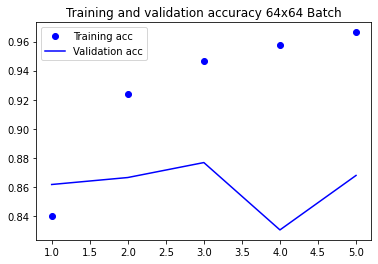

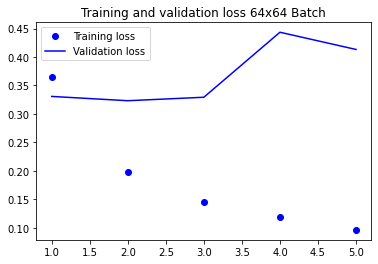

In [41]:
# Model Statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy 64x64 Batch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss 64x64 Batch')
plt.legend()
plt.show()

In [42]:
# Time per epoch in seconds
time_callback.times

[374.400395154953,
 373.4460668563843,
 372.14764618873596,
 371.5936870574951,
 371.99629068374634]

In [43]:
# Model performance on Test Data
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=64).batch(64).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=512, verbose=0)[1]))

Test set accuracy is 0.8386


In [44]:
# Vgg16 based model We will Use

new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [45]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1000).repeat().batch(64).prefetch(4)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(64).prefetch(4)

In [46]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback = TimeHistory()
history = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=1, epochs=5,callbacks=[time_callback], steps_per_epoch=4096, validation_steps=512)

Epoch 1/5
   6/4096 [..............................] - ETA: 5:54 - loss: 0.6939 - acc: 0.4922WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0297s vs `on_train_batch_end` time: 0.0568s). Check your callbacks.


4096/4096 [==============================] - 370s 90ms/step - loss: 0.3736 - acc: 0.8365 - val_loss: 0.3477 - val_acc: 0.8564
Epoch 2/5
4096/4096 [==============================] - 368s 90ms/step - loss: 0.1997 - acc: 0.9225 - val_loss: 0.3210 - val_acc: 0.8748
Epoch 3/5
4096/4096 [==============================] - 368s 90ms/step - loss: 0.1468 - acc: 0.9466 - val_loss: 0.4770 - val_acc: 0.8101
Epoch 4/5
4096/4096 [==============================] - 368s 90ms/step - loss: 0.1194 - acc: 0.9574 - val_loss: 0.2924 - val_acc: 0.8835
Epoch 5/5
4096/4096 [==============================] - 368s 90ms/step - loss: 0.0968 - acc: 0.9663 - val_loss: 0.4833 - val_acc: 0.8446


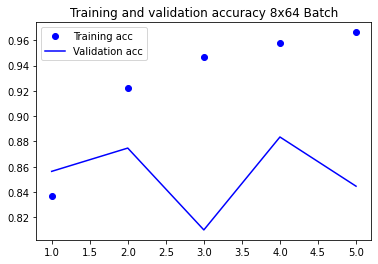

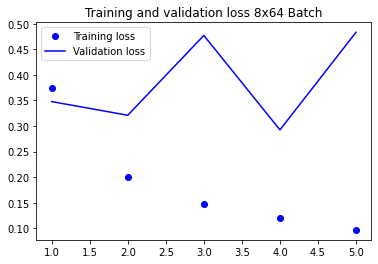

In [47]:
# Model Statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy 8x64 Batch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss 8x64 Batch')
plt.legend()
plt.show()

In [48]:
# Time per epoch in seconds
time_callback.times

[369.7237591743469,
 368.3138952255249,
 368.23123121261597,
 368.1734938621521,
 367.86717343330383]

In [49]:
# Model performance on Test Data
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(64).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=512, verbose=0)[1]))

Test set accuracy is 0.8250
